In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
data = pd.read_csv("preprocessed-data/krwvnd.csv")
data.rename(columns={'Date': 'ds', 'Close':'y'}, inplace=True)
data["ds"] = pd.to_datetime(data["ds"])
data

,ds,y
0,2004-01-02,12.661377
1,2004-01-05,12.597076
2,2004-01-06,12.724485
3,2004-01-07,12.622449
4,2004-01-08,12.665998
...,...,...
5974,2023-10-27,18.123903
5975,2023-10-28,18.123247
5976,2023-10-29,18.123247
5977,2023-10-30,18.211071


In [4]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

4783 1196


In [5]:
# def create_dataset(dataset, look_back=1):
#     data_prof = dataset.copy()
#     for i in range(look_back, 0, -1):
#         data_prof[f'y-{i}'] = dataset['y'].shift(i)
#     data_prof = data_prof.dropna()
#     return data_prof


In [6]:
# look_back = 1
# train_pf = create_dataset(train, look_back)
# test_pf = create_dataset(test, look_back)

In [7]:
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'], #['additive', 'multiplicative']
    'changepoint_prior_scale': [0.001, 0.01, 0.05], #[0.01, 0.1, 0.5]
    'seasonality_prior_scale': [1, 10, 30], #[1, 10, 30]
}


In [8]:
best_params = {}
best_score = float('inf')

In [9]:
for mode in param_grid['seasonality_mode']:
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Create a model with the current hyperparameters
            model = Prophet(seasonality_mode=mode, 
                            changepoint_prior_scale=cps, 
                            seasonality_prior_scale=sps, 
                            )
            model.fit(train)

            # Evaluate the model using Mean Squared Error (MSE) and cross validation
            # df_cv = cross_validation(model, initial='4783 days', period='30 days', horizon='1 days')
            # score = mean_squared_error(df_cv['y'], df_cv['yhat'])
            future = model.make_future_dataframe(periods=train_size)
            forecast = model.predict(future)
            y_true = test['y'].values
            y_pred = forecast['yhat'].values[-len(test):]
            score = mean_squared_error(y_true, y_pred)
            print(mode, cps, sps, score)

            # Update best parameters
            if score < best_score:
                best_score = score
                best_params = {
                    'seasonality_mode': mode,
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

22:00:12 - cmdstanpy - INFO - Chain [1] start processing
22:00:12 - cmdstanpy - INFO - Chain [1] done processing
22:00:13 - cmdstanpy - INFO - Chain [1] start processing


additive 0.001 1 23.978490562811995


22:00:14 - cmdstanpy - INFO - Chain [1] done processing
22:00:15 - cmdstanpy - INFO - Chain [1] start processing


additive 0.001 10 24.135878963994905


22:00:15 - cmdstanpy - INFO - Chain [1] done processing
22:00:17 - cmdstanpy - INFO - Chain [1] start processing


additive 0.001 30 24.667910945202316


22:00:18 - cmdstanpy - INFO - Chain [1] done processing
22:00:19 - cmdstanpy - INFO - Chain [1] start processing


additive 0.01 1 7.19593782391284


22:00:20 - cmdstanpy - INFO - Chain [1] done processing
22:00:22 - cmdstanpy - INFO - Chain [1] start processing


additive 0.01 10 6.921349693901905


22:00:22 - cmdstanpy - INFO - Chain [1] done processing
22:00:24 - cmdstanpy - INFO - Chain [1] start processing


additive 0.01 30 7.351066352078412


22:00:25 - cmdstanpy - INFO - Chain [1] done processing
22:00:27 - cmdstanpy - INFO - Chain [1] start processing


additive 0.05 1 24.383946079777427


22:00:28 - cmdstanpy - INFO - Chain [1] done processing
22:00:30 - cmdstanpy - INFO - Chain [1] start processing


additive 0.05 10 24.396802157327


22:00:31 - cmdstanpy - INFO - Chain [1] done processing
22:00:33 - cmdstanpy - INFO - Chain [1] start processing


additive 0.05 30 24.164197824147323


22:00:33 - cmdstanpy - INFO - Chain [1] done processing
22:00:34 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.001 1 25.256241761659435


22:00:35 - cmdstanpy - INFO - Chain [1] done processing
22:00:36 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.001 10 25.037439345374768


22:00:37 - cmdstanpy - INFO - Chain [1] done processing
22:00:38 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.001 30 25.07916258152836


22:00:39 - cmdstanpy - INFO - Chain [1] done processing
22:00:41 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.01 1 6.97614419937513


22:00:41 - cmdstanpy - INFO - Chain [1] done processing
22:00:43 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.01 10 6.397683595589247


22:00:44 - cmdstanpy - INFO - Chain [1] done processing
22:00:45 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.01 30 6.645875165853968


22:00:46 - cmdstanpy - INFO - Chain [1] done processing
22:00:48 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.05 1 24.123297489357483


22:00:49 - cmdstanpy - INFO - Chain [1] done processing
22:00:51 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.05 10 23.86577969633217


22:00:52 - cmdstanpy - INFO - Chain [1] done processing


multiplicative 0.05 30 24.44233674949205


In [10]:
best_params

{'seasonality_mode': 'multiplicative',
 'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 10}

In [11]:
best_model = Prophet(**best_params)
best_model.fit(train)

22:00:54 - cmdstanpy - INFO - Chain [1] start processing
22:00:54 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = best_model.make_future_dataframe(periods=train_size)
forecast = best_model.predict(future)


In [13]:
y_true = test['y'].values
y_pred = forecast['yhat'].values[-len(test):]

In [14]:
mse = mean_squared_error(y_true, y_pred)
mse

6.397683595589247

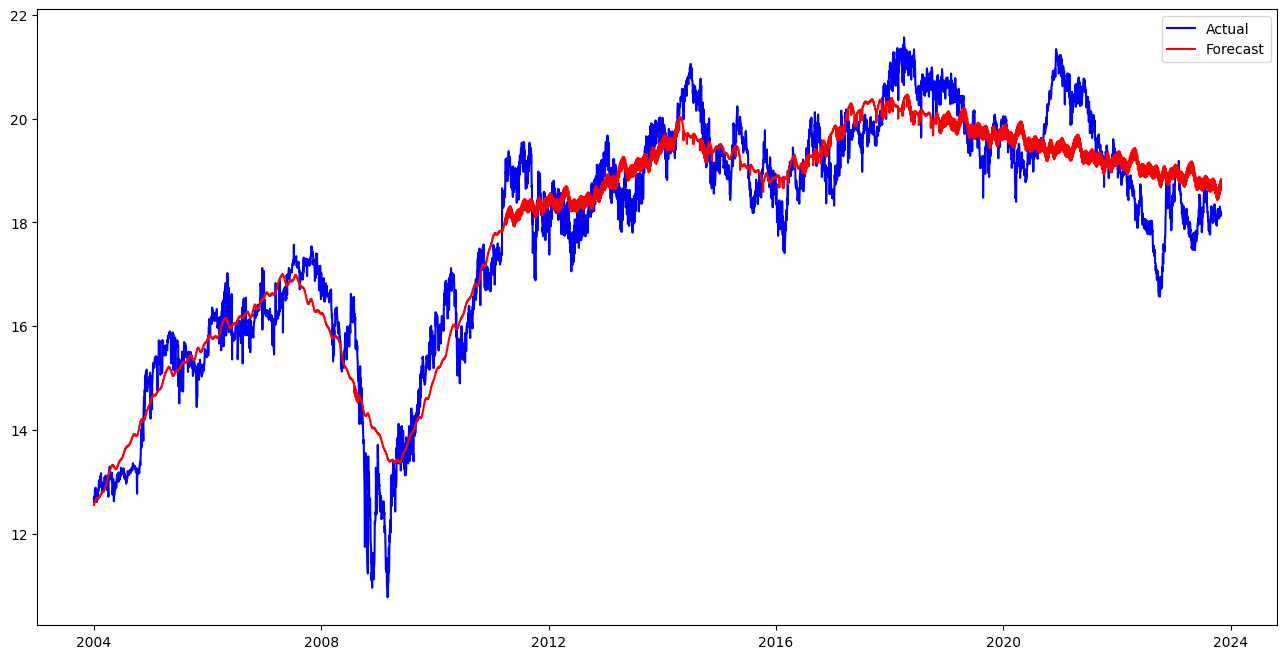

In [15]:
plt.figure(figsize=(16,8))
plt.plot(data['ds'], data['y'], label='Actual', color='blue')
plt.plot(forecast['ds'][:len(data)], forecast['yhat'][:len(data)], label='Forecast', color='red')
plt.legend()
plt.show()

KRW-KZT

In [16]:
data = pd.read_csv("preprocessed-data/krwkzt.csv")
data.rename(columns={'Date': 'ds', 'Close':'y'}, inplace=True)
data["ds"] = pd.to_datetime(data["ds"])
data

,ds,y
0,2004-01-02,0.115789
1,2004-01-05,0.114777
2,2004-01-06,0.115528
3,2004-01-07,0.114479
4,2004-01-08,0.115056
...,...,...
5949,2023-10-27,0.346066
5950,2023-10-28,0.346054
5951,2023-10-29,0.346054
5952,2023-10-30,0.349440


In [17]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

4763 1191


In [18]:
best_params = {}
best_score = float('inf')

In [19]:
for mode in param_grid['seasonality_mode']:
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Create a model with the current hyperparameters
            model = Prophet(seasonality_mode=mode, 
                            changepoint_prior_scale=cps, 
                            seasonality_prior_scale=sps, 
                            )
            model.fit(train)

            # Evaluate the model using Mean Squared Error (MSE) and cross validation
            # df_cv = cross_validation(model, initial='4783 days', period='30 days', horizon='1 days')
            # score = mean_squared_error(df_cv['y'], df_cv['yhat'])
            future = model.make_future_dataframe(periods=train_size)
            forecast = model.predict(future)
            y_true = test['y'].values
            y_pred = forecast['yhat'].values[-len(test):]
            score = mean_squared_error(y_true, y_pred)
            print(mode, cps, sps, score)

            # Update best parameters
            if score < best_score:
                best_score = score
                best_params = {
                    'seasonality_mode': mode,
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

22:00:56 - cmdstanpy - INFO - Chain [1] start processing
22:00:56 - cmdstanpy - INFO - Chain [1] done processing
22:00:58 - cmdstanpy - INFO - Chain [1] start processing


additive 0.001 1 0.12462707230098484


22:00:58 - cmdstanpy - INFO - Chain [1] done processing
22:01:00 - cmdstanpy - INFO - Chain [1] start processing


additive 0.001 10 0.12370750872509471


22:01:00 - cmdstanpy - INFO - Chain [1] done processing
22:01:01 - cmdstanpy - INFO - Chain [1] start processing


additive 0.001 30 0.1238324492900399


22:01:02 - cmdstanpy - INFO - Chain [1] done processing
22:01:04 - cmdstanpy - INFO - Chain [1] start processing


additive 0.01 1 0.02746955011865219


22:01:06 - cmdstanpy - INFO - Chain [1] done processing
22:01:07 - cmdstanpy - INFO - Chain [1] start processing


additive 0.01 10 0.027240594443712983


22:01:08 - cmdstanpy - INFO - Chain [1] done processing
22:01:09 - cmdstanpy - INFO - Chain [1] start processing


additive 0.01 30 0.025589319067898148


22:01:11 - cmdstanpy - INFO - Chain [1] done processing
22:01:13 - cmdstanpy - INFO - Chain [1] start processing


additive 0.05 1 0.02625292159565444


22:01:14 - cmdstanpy - INFO - Chain [1] done processing
22:01:15 - cmdstanpy - INFO - Chain [1] start processing


additive 0.05 10 0.025975073578672236


22:01:17 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing


additive 0.05 30 0.026299486750242327


22:01:19 - cmdstanpy - INFO - Chain [1] done processing
22:01:20 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.001 1 0.12459048969832062


22:01:20 - cmdstanpy - INFO - Chain [1] done processing
22:01:22 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.001 10 0.1246740772839498


22:01:22 - cmdstanpy - INFO - Chain [1] done processing
22:01:24 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.001 30 0.12252321479196518


22:01:25 - cmdstanpy - INFO - Chain [1] done processing
22:01:26 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.01 1 0.028978317530237614


22:01:28 - cmdstanpy - INFO - Chain [1] done processing
22:01:30 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.01 10 0.028308572257823184


22:01:32 - cmdstanpy - INFO - Chain [1] done processing
22:01:33 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.01 30 0.028140312760368047


22:01:35 - cmdstanpy - INFO - Chain [1] done processing
22:01:36 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.05 1 0.026640208198754976


22:01:38 - cmdstanpy - INFO - Chain [1] done processing
22:01:39 - cmdstanpy - INFO - Chain [1] start processing


multiplicative 0.05 10 0.026831446485622603


22:01:41 - cmdstanpy - INFO - Chain [1] done processing


multiplicative 0.05 30 0.026748701349673512


In [20]:
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 30}

In [21]:
best_model = Prophet(**best_params)
best_model.fit(train)

22:01:42 - cmdstanpy - INFO - Chain [1] start processing
22:01:43 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = best_model.make_future_dataframe(periods=train_size)
forecast = best_model.predict(future)


In [23]:
y_true = test['y'].values
y_pred = forecast['yhat'].values[-len(test):]

In [24]:
mse = mean_squared_error(y_true, y_pred)
mse

0.025589319067898148

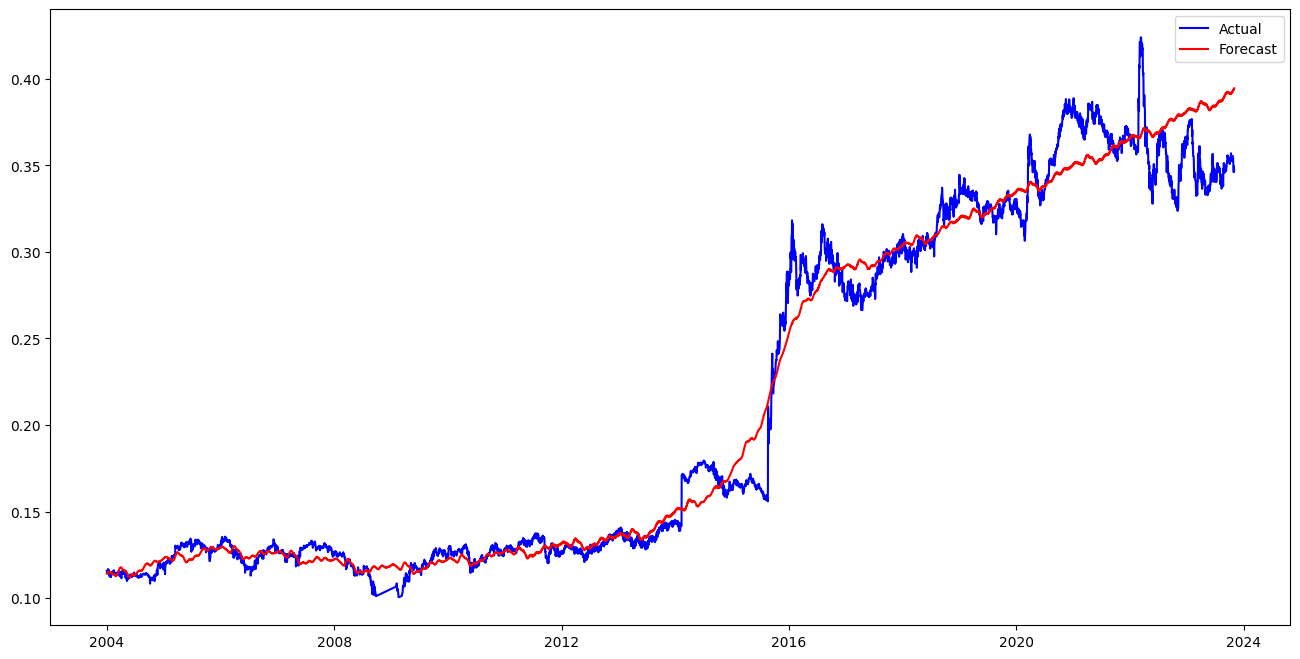

In [25]:
plt.figure(figsize=(16,8))
plt.plot(data['ds'], data['y'], label='Actual', color='blue')
plt.plot(forecast['ds'][:len(data)], forecast['yhat'][:len(data)], label='Forecast', color='red')
plt.legend()
plt.show()